### Interpret Results

In [1]:
from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from src.dataset import load_dataset

In [37]:
data_dir = 'datasets_toy_regression/linear_noise_2'

train, test, labels = load_dataset(data_path=get_src_dir_path(data_dir), data_type="toy_regression", data_split_seed=0)

Text(0.5, 1.0, 'Train Data')

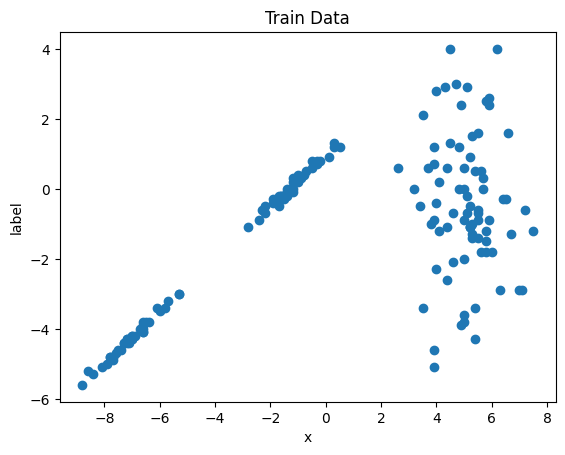

In [38]:
fig, ax = plt.subplots()

ax.scatter(train["x"], train["label"])
ax.set_xlabel("x")
ax.set_ylabel("label")
ax.set_title("Train Data")

### Hypothesis Testing

In [5]:
from src.prompt import ToyRegressionPrompt
from src.utils import ToyClassificationUtils, extract
from src.chat import chat_response_only
import scipy.stats as stats

prompter = ToyRegressionPrompt()

feature_columns = ToyClassificationUtils.get_feature_columns(train)

D_rows = train.sample(n=15, random_state=0)
D_feature_stds = D_rows[feature_columns].std().to_numpy()

D_note_label_df = D_rows[['note', 'label']]

x_row = ToyClassificationUtils.create_x_row_from_x_features("{'x1': [4.5]}", feature_columns)

In [46]:
prompt = prompter.get_general_prompt(D_note_label_df, x_row['note'][0], 1)

predictions = []
for i in range(100):
    response = chat_response_only(prompt, i)
    prediction = extract(response)
    predictions.append(prediction)


In [66]:
num_outliers_to_remove = int(0.03 * len(predictions))

outlier_free_predictions = np.sort(predictions)[num_outliers_to_remove:-num_outliers_to_remove]

mean = np.mean(outlier_free_predictions)
std = np.std(outlier_free_predictions)

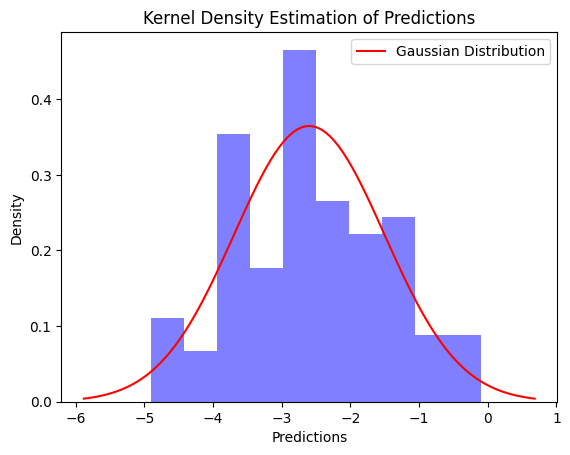

In [67]:
plt.figure()
# Plot kernel density estimation
plt.hist(outlier_free_predictions, bins=10, density=True, alpha=0.5, color='blue')
plt.title('Kernel Density Estimation of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Density')

# Plot gaussian distribution
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
plt.plot(x, y, color='red', label='Gaussian Distribution')

plt.legend()
plt.show()

In [68]:
from scipy import stats

print(stats.shapiro(outlier_free_predictions))

ShapiroResult(statistic=0.9859634932873585, pvalue=0.4159986001571069)


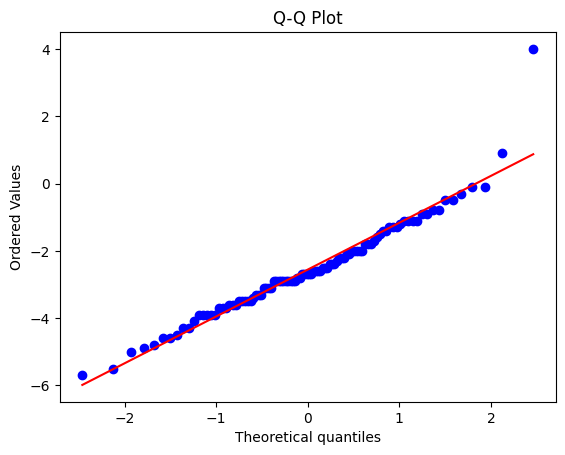

In [65]:
stats.probplot(predictions, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

#### Checking Tokenization

In [ ]:
import requests

# tokenize

url = "http://localhost:8000/tokenize"
headers = {"Content-Type": "application/json"}
data = {
    "model": "Qwen/Qwen2.5-14B",
    "prompt": prompt,
}

response = requests.post(url, headers=headers, json=data).json()

tokens = response["tokens"]

In [20]:

# detokenize

url2 = "http://localhost:8000/detokenize"
headers2 = {"Content-Type": "application/json"}

tokenized_prompt = []

for token in tokens:
    data2 = {
        "model": "Qwen/Qwen2.5-14B",
        "tokens": [token],
    }
    response2 = requests.post(url2, headers=headers2, json=data2).json()
    tokenized_prompt.append(response2["prompt"])


In [21]:
split_prompt_string = "|".join(tokenized_prompt)

#### Plotting

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from src.utils import ToyRegressionUtils

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [38]:
results_directory = 'results/linear_noise_1/experiment_2/'


In [39]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [40]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        

In [41]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True, upper_bound_by_total_U=True)

In [42]:
feature_column = ToyRegressionUtils.get_feature_columns(D_data)[0]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_mean_list = []
prob_y_xz_std_list = []
prob_y_x_mean_list = []
prob_y_x_std_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        x_x1 = z_df[f'x_{feature_column}'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
        
        # get the prob_y_xz and prob_y_x
        prob_y_x_mean = z_df["p(y|x,D)_mean"].values[min_Va_index]
        prob_y_x_std = z_df["p(y|x,D)_std"].values[min_Va_index]
        prob_y_xz_mean = z_df["p(y|x,z,D)_mean"].values[min_Va_index]
        prob_y_xz_std = z_df["p(y|x,z,D)_std"].values[min_Va_index]
        
        prob_y_x_mean_list.append(prob_y_x_mean)
        prob_y_x_std_list.append(prob_y_x_std)
        prob_y_xz_mean_list.append(prob_y_xz_mean)
        prob_y_xz_std_list.append(prob_y_xz_std)
        
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
        
    except:
        pass
    
# Create a dataframe from the lists
data = {f'x_{feature_column}': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list,
        'prob_y_xz_mean': prob_y_xz_mean_list,
        'prob_y_xz_std': prob_y_xz_std_list,
        'prob_y_x_mean': prob_y_x_mean_list,
        'prob_y_x_std': prob_y_x_std_list,
        }

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by=f'x_{feature_column}')

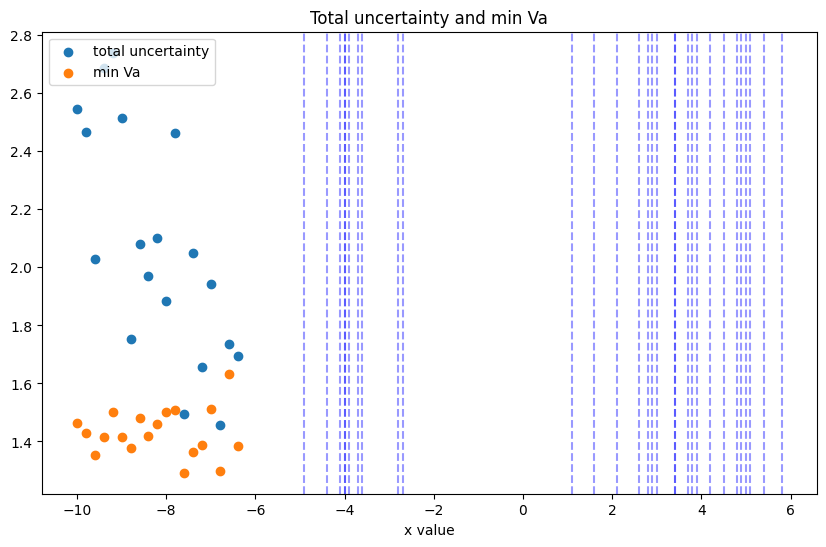

In [43]:
# plot x vs total uncertainty and min Va

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], label='total uncertainty')
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], label='min Va')

# vertical line for the true x
for i, row in D_data.iterrows():
    plt.axvline(x=row[feature_column], color='b', linestyle='--', alpha=0.4)
plt.title(f"Total uncertainty and min Va")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['total_uncertainty'], color='red')
#             break

# plt.yscale('log')
plt.xlabel('x value')
plt.legend()
plt.show()

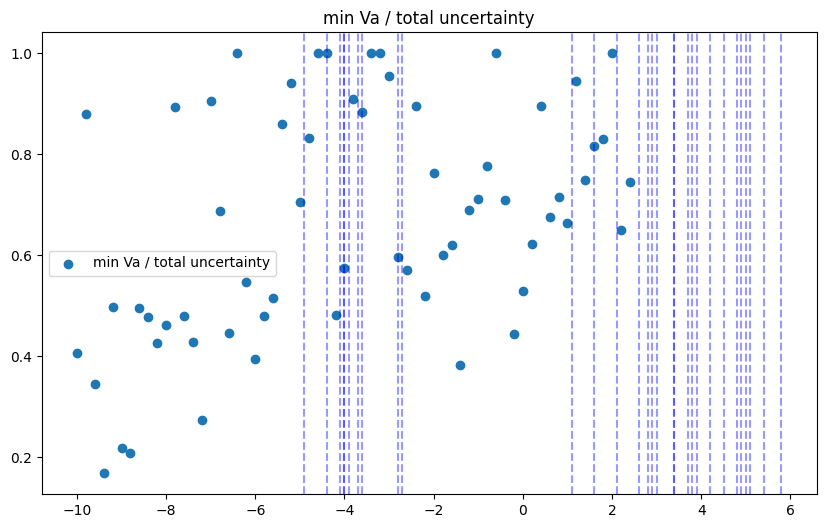

In [25]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = np.exp(shots_df['min_Va'] - shots_df['total_uncertainty'])

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va_total_uncertainty_ratio'], label='min Va / total uncertainty')

# vertical line for the true x
for i, row in D_data.iterrows():
    plt.axvline(x=row[feature_column], color='b', linestyle='--', alpha=0.4)
plt.title(f"min Va / total uncertainty")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['min_Va_total_uncertainty_ratio'], color='red')
#             break

plt.legend()
plt.show()

Text(0.5, 1.0, 'mean and std of prob_y_x')

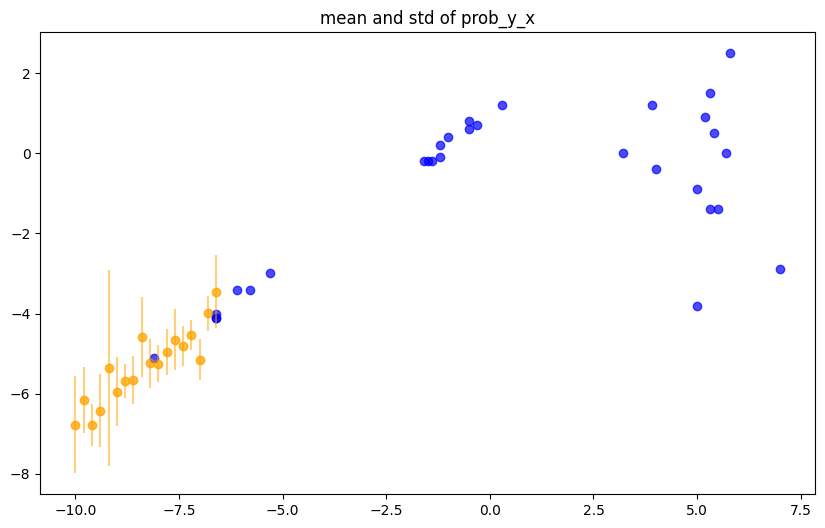

In [12]:
# plot mean of prob_y_x with std error 

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], label='mean of prob_y_x', color='orange', alpha=0.5)
plt.errorbar(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], yerr=shots_df['prob_y_x_std'], fmt='o', color='orange', alpha=0.5, label='std of prob_y_x')

# scatter plot for D
for i, row in D_data.iterrows():
    plt.scatter(row[feature_column], row['label'], color='b', alpha=0.7)
plt.title(f"mean and std of prob_y_x")
